In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.8 MB/s eta 0:00:00


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import pywt
import cv2
import os
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning

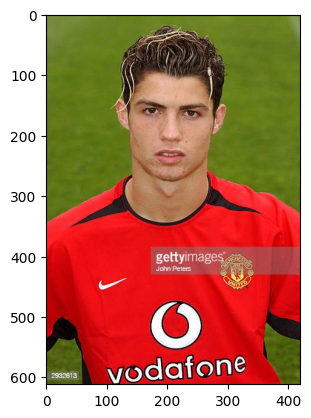

In [ ]:
img = cv2.imread('/content/drive/MyDrive/DataSet/train/Ronaldo/ronaldo_(2).jpg')
img = cv2.cvtColor(img ,cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml

--2024-11-04 21:38:41--  https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml [following]
--2024-11-04 21:38:42--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  5.15MB/s    in 0.2s    

20

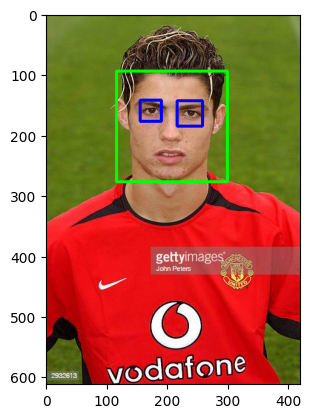

In [ ]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eyes_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray ,1.3 , 4)
for (x,y,h,w) in faces :
  cv2.rectangle(img ,(x,y),(x+w ,y+h),(0,255,0),3)

  roi_gray=gray[y:y+h ,x:x+w] # get face part
  roi_color=img[y:y+h ,x:x+w]
  eyes = eyes_cascade.detectMultiScale(roi_gray) # detect eyes
  for(ex,ey,eh,ew) in eyes :
      cv2.rectangle(roi_color ,(ex,ey),(ex+ew ,ey+eh),(0,0,255),3)

plt.imshow(img)
plt.show()

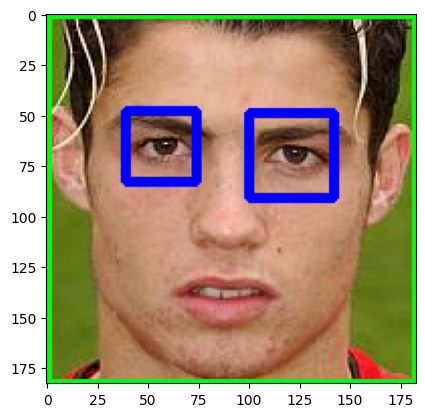

In [ ]:
plt.imshow(roi_color)

In [ ]:
def get_face_if_2_eyes(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray ,1.3 , 4)
  for (x,y,h,w) in faces:
    roi_color=img[y:y+h ,x:x+w]
    eyes = eyes_cascade.detectMultiScale(roi_gray) # detect eyes
    if len(eyes) == 2:
      return roi_color

In [ ]:
train_path = '/content/drive/MyDrive/DataSet/train/'
folder_name = [name for name in os.listdir(train_path)]
folder_name

['Kane_Williamson', 'Maria_Sharapova', 'Kobe_Bryant', 'Ronaldo']

In [ ]:
folder_path = '/content/drive/MyDrive/DataSet/head/'

for name in folder_name:
  path = folder_path + name
  if not os.path.exists(path):
    os.makedirs(path)
    print(f"Folder '{path}' created successfully.")
  else:
    print(f"Folder '{path}' already exists.")

Folder '/content/drive/MyDrive/DataSet/head/Kane_Williamson' created successfully.
Folder '/content/drive/MyDrive/DataSet/head/Maria_Sharapova' created successfully.
Folder '/content/drive/MyDrive/DataSet/head/Kobe_Bryant' created successfully.
Folder '/content/drive/MyDrive/DataSet/head/Ronaldo' created successfully.


In [ ]:
for name in folder_name:
  path = train_path + name
  for img_name in os.listdir(path):
    img = cv2.imread(path + '/' + img_name)
    img = get_face_if_2_eyes(img)
    if img is not None:
      cv2.imwrite(f"{folder_path}{name}/{img_name}" ,img)

# Wavelet transform

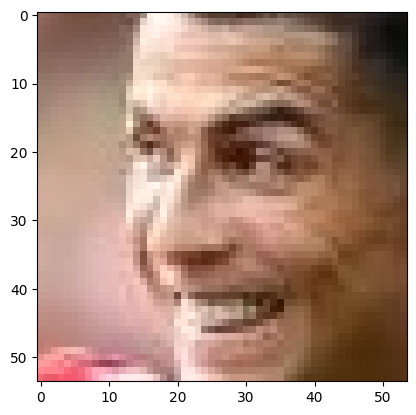

In [27]:
cropped_img = cv2.imread('/content/drive/MyDrive/DataSet/head/Ronaldo/ronaldo_(100).jpg')
cropped_img = cv2.cvtColor(cropped_img ,cv2.COLOR_BGR2RGB)
plt.imshow(cropped_img)

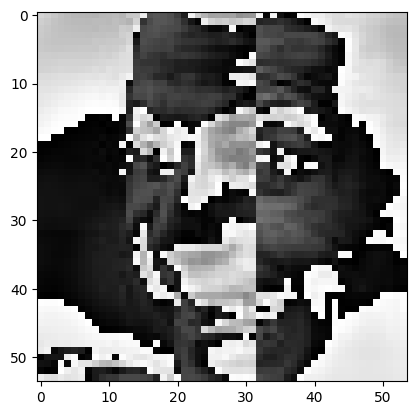

In [28]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [29]:
FACE_PATH = '/content/drive/MyDrive/DataSet/head/'
features = []
labels = []
label = 0
dic = {}

for folder_name in os.listdir(FACE_PATH):
  dic[folder_name] = label
  label += 1
  folder_path = os.path.join(FACE_PATH, folder_name)
  for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    o_img = cv2.resize(img, (32, 32))
    w_img = w2d(img, 'db1', 5)
    w_img = cv2.resize(w_img, (32, 32))
    combined_img = np.vstack((o_img.reshape(32 * 32 * 3, 1), w_img.reshape(32 * 32, 1)))

    features.append(combined_img)
    labels.append(dic[folder_name])

In [30]:
dic

{'Kane_Williamson': 0, 'Maria_Sharapova': 1, 'Kobe_Bryant': 2, 'Ronaldo': 3}

In [31]:
len(features)

133

In [32]:
len(features[0])

4096

In [33]:
features = np.array(features).reshape(len(features), 4096).astype(float)
labels = np.array(labels)

In [34]:
features[0]

array([204., 204., 204., ...,  68.,  68.,   2.])

In [35]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3])

In [36]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.2,random_state=42,stratify=labels)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train),pipe.score(X_test, y_test)

(1.0, 0.6296296296296297)

# Grid Search

In [40]:
model = {
    'svm': {
        'model': SVC(),
        'params' : {
              'C': [1,10,100,1000],
              'kernel': ['rbf', 'linear'],
            }
        },

    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,20,50,100]
        }
    },

    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,50,100]
        }
    }
}

In [41]:
scores = []
best_estimators = {}

for model_name, mp in model.items():
  classifier = GridSearchCV(mp['model'], mp['params'], cv=5)
  classifier.fit(X_train, y_train)
  scores.append({
      'model': model_name,
      'best_score': classifier.best_score_,
      'best_params': classifier.best_params_
  })
  best_estimators[model_name] = classifier.best_estimator_

df = pd.DataFrame(scores, columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.783983,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.708658,{'n_estimators': 100}
2,logistic_regression,0.810823,{'C': 1}


In [42]:
best_estimator = best_estimators['logistic_regression']
best_estimator.score(X_test, y_test)

0.7407407407407407

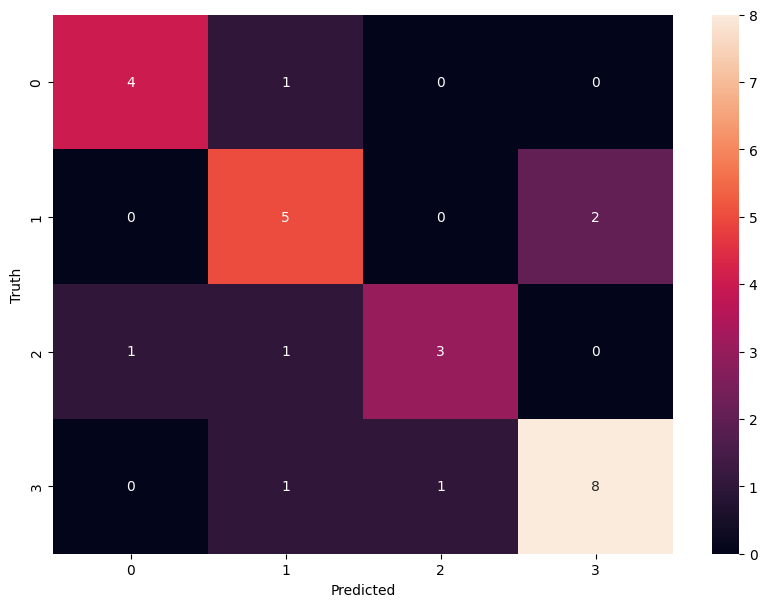

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [44]:
!pip install joblib

In [45]:
import joblib
joblib.dump(best_estimator, 'best_estimator.pkl')

['best_estimator.pkl']

In [46]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(dic))